In [1]:
%pylab inline
from astropy.io import fits
import glob
import pandas as pd
from pandas import DataFrame
from scipy.interpolate import interp1d
from nirspec import gluespec #,divspec
from spec_utils import vgeo#, vlsr_to_vehelio
import pdb as pdb
import astropy
from astropy import units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord
from astroquery.hitran import Hitran
from flux_calculator import extract_hitran_data, calc_fluxes, extract_vup, make_rotation_diagram
import numpy
from slabspec import extract_hitran_data
import matplotlib.patches as mpatches

Populating the interactive namespace from numpy and matplotlib


C:\Users\hanna\Anaconda\lib\site-packages\pyfits\__init__.py:22: PyFITSDeprecationWarning: PyFITS is deprecated, please use astropy.io.fits
  PyFITSDeprecationWarning)  # noqa


In [5]:
def vproj(mycoord):
    vlsr=20.0*np.array([0.014498, -0.865863, 0.500071])  
    ra_rad=mycoord.ra.radian
    dec_rad=mycoord.dec.radian
    vproj = vlsr[0]*np.cos(dec_rad)*np.cos(ra_rad) + vlsr[1]*np.cos(dec_rad)*np.sin(ra_rad) + vlsr[2]*np.sin(dec_rad)
    return vproj
def vlsr_to_vhelio(mycoord, myvlsr):
    myvproj=vproj(mycoord)
    myvhelio=myvlsr-myvproj
    return myvhelio

In [2]:
#10/22/12
hdulist20121022=fits.open('/Users/hanna/Desktop/URSI/LkCa15_20121022_glue.fits')
data20121022 = hdulist20121022[1].data
#12/30/12
hdulist20121230=fits.open('/Users/hanna/Desktop/URSI/LkCa15_20121230_glue.fits')
data20121230 = hdulist20121230[1].data
#10/20/13
hdulist20131020=fits.open('/Users/hanna/Desktop/URSI/LkCa15_20131020_glue.fits')
data20131020 = hdulist20131020[1].data
#12/23/13
hdulist20131223=fits.open('/Users/hanna/Desktop/URSI/LkCa15_20131223_glue.fits')
data20131223 = hdulist20131223[1].data

In [10]:
#Telluric Cutoff
no = 0.60
from astropy.table import Table
t = Table.read('/Users/hanna/Desktop/URSI/LkCa15_20121022_glue.fits')
df1012 = t.to_pandas()
df1012 = DataFrame(df1012, columns = ['wave', 'div', 'src', 'std'])
df1012.loc[df1012['std'] >0, 'std'] = (df1012['std']/1.188452) #normalize std
df1012.loc[df1012['std'] <no, 'div'] = None

t = Table.read('/Users/hanna/Desktop/URSI/LkCa15_20121230_glue.fits')
df1212 = t.to_pandas()
df1212 = DataFrame(df1212, columns = ['wave', 'div', 'src', 'std'])
df1212.loc[df1212['std'] >0, 'std'] = (df1212['std']/1.299657) #normalize std
df1212.loc[df1212['std'] <no, 'div'] = None

t = Table.read('/Users/hanna/Desktop/URSI/LkCa15_20131020_glue.fits')
df1013 = t.to_pandas()
df1013 = DataFrame(df1013, columns = ['wave', 'div', 'src', 'std'])
df1013.loc[df1013['std'] >0, 'std'] = (df1013['std']/1.342216) #normalize std
df1013.loc[df1013['std'] <no, 'div'] = None

t = Table.read('/Users/hanna/Desktop/URSI/LkCa15_20131223_glue.fits')
df1213 = t.to_pandas()
df1213 = DataFrame(df1213, columns = ['wave', 'div', 'src', 'std'])
df1213.loc[df1213['std'] >0, 'std'] = (df1213['std']/1.294916) #normalize std
df1213.loc[df1213['std'] <no, 'div'] = None


In [36]:
#Doppler Shift
c = 3*10**5 #km/s

mydate1012=Time('2012-10-22T00:00:00.0', format='isot', scale='utc') 
mydate1212=Time('2012-12-30T00:00:00.0', format='isot', scale='utc')
mydate1013=Time('2013-10-20T00:00:00.0', format='isot', scale='utc')
mydate1213=Time('2013-12-23T00:00:00.0', format='isot', scale='utc')

mycoord=SkyCoord('4h39m17.79s', '+22d21m03.48s', frame='icrs')

vhelio = vlsr_to_vhelio(mycoord, 17.65) #source in evernote

#Calculate the heliocentric velocity (Earth-induced + intrinsic)
myv1012=vgeo(mydate1012, mycoord, vhelio)
myv1212=vgeo(mydate1212, mycoord, vhelio)
myv1013=vgeo(mydate1013, mycoord, vhelio)
myv1213=vgeo(mydate1213, mycoord, vhelio)

print(myv1012)
print(myv1212)
print(myv1013)
print(myv1213)

df1012.loc[df1012['wave']> 0, 'wave'] = (df1012['wave']*(1-myv1012/c)) #this is how I applied the doppler shift to each point in the data set
df1212.loc[df1212['wave']> 0, 'wave'] = (df1212['wave']*(1-myv1212/c)) 
df1013.loc[df1013['wave']> 0, 'wave'] = (df1013['wave']*(1-myv1013/c))
df1213.loc[df1213['wave']> 0, 'wave'] = (df1213['wave']*(1-myv1213/c))

8.90000995021741
42.61509009106246
8.05501329297013
39.08668401333668


In [47]:
df1013.loc[df1013['wave']> 0, 'wave'] = (df1013['wave']-0.0009)

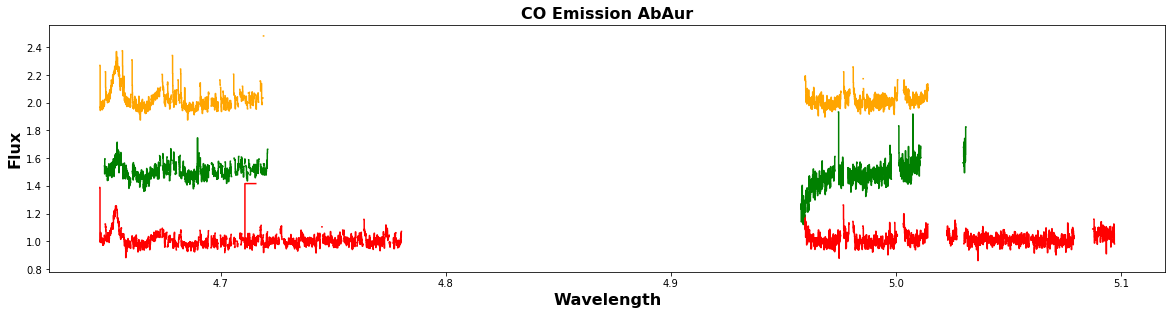

In [48]:
fig = plt.figure(figsize(20,10))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(211)
ax3 = fig.add_subplot(211)
ax4 = fig.add_subplot(211)

ax1.set_title('CO Emission AbAur', fontsize=16, fontweight='bold')
ax1.set_xlabel('Wavelength', fontsize=16, fontweight='bold')
ax1.set_ylabel('Flux', fontsize=16, fontweight='bold')

#ax1.plot(df1012['wave'],df1012['div']+0,linestyle='steps-mid', color = 'blue')
ax2.plot(df1212['wave'],df1212['div'],linestyle='steps-mid', color = 'red')
ax3.plot(df1013['wave'],df1013['div']+0.5,linestyle='steps-mid', color = 'green')
ax4.plot(df1213['wave'],df1213['div']+1,linestyle='steps-mid', color = 'orange')

<Figure size 1440x720 with 0 Axes>

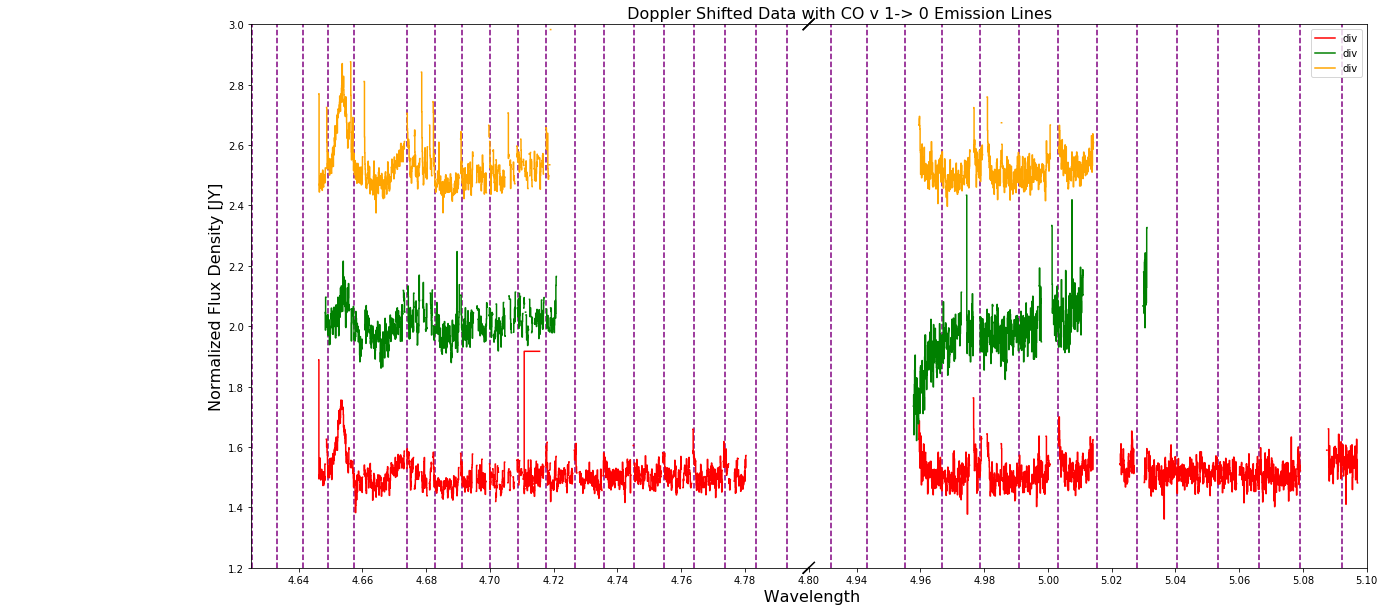

In [49]:
out_all=extract_hitran_data('CO',4.6,5.2)  #astropy table
lineflux_data=extract_vup(out_all,1)
HitCO = lineflux_data['wave']
#print(HitCO)

plt.figure(figsize(20,10))
axa = fig.add_subplot(211)
axb = fig.add_subplot(211)

f, (axa, axb) = plt.subplots(1, 2,sharex=False, sharey=True)
plt.subplots_adjust(wspace=0) #set to zero, if you want to join the two plots

axa.set_title('                                                                                                                         Doppler Shifted Data with CO v 1-> 0 Emission Lines', fontsize=16)
axa.set_xlabel('                                                                                                              Wavelength', fontsize=16)
axa.set_ylabel('Normalized Flux Density [JY]', fontsize=16)

#axa.plot(df1012['wave'],df1012['div'],linestyle='steps-mid', color = 'blue')
#axb.plot(df1012['wave'],df1012['div'],linestyle='steps-mid', color = 'blue')
axa.plot(df1212['wave'],df1212['div']+0.5,linestyle='steps-mid', color = 'red')
axb.plot(df1212['wave'],df1212['div']+0.5,linestyle='steps-mid', color = 'red')
axa.plot(df1013['wave'],df1013['div']+1,linestyle='steps-mid', color = 'green')
axb.plot(df1013['wave'],df1013['div']+1,linestyle='steps-mid', color = 'green')
axa.plot(df1213['wave'],df1213['div']+1.5,linestyle='steps-mid', color = 'orange')
axb.plot(df1213['wave'],df1213['div']+1.5,linestyle='steps-mid', color = 'orange')

ymin = 1.2
ymax = 3
plt.ylim(ymin,ymax)
axa.set_xlim(4.625, 4.8)
axb.set_xlim(4.925, 5.1)

axa.spines['right'].set_visible(False)
axb.spines['left'].set_visible(False)
axb.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=False) # labels along the bottom edge are off

d=0.010
kwargs = dict(transform=axa.transAxes, color='k', clip_on=False)
axa.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal
axa.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)
kwargs.update(transform=axb.transAxes)  # switch to the bottom axes
axb.plot((-d, +d), (-d, +d), **kwargs)  # bottom-left diagonal
axb.plot((-d, +d), (1 - d, 1 + d), **kwargs)

for xc in HitCO:
    axa.vlines(x=xc, ymin=ymin, ymax=ymax, color='purple', linestyle='--')
    axb.vlines(x=xc, ymin=ymin, ymax=ymax, color='purple', linestyle='--')
    #print(xc)
axb.legend()

plt.show()


Text(0, 0.5, 'Flux [Jy]')

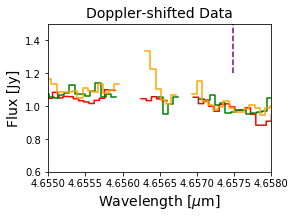

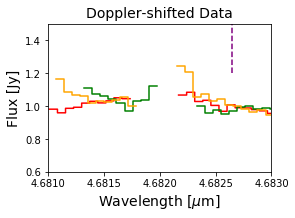

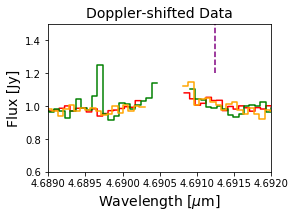

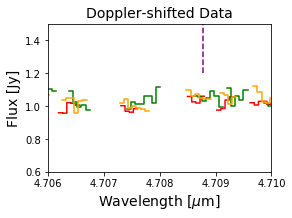

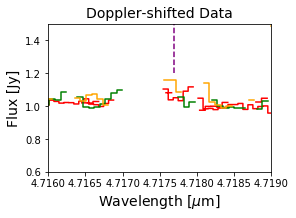

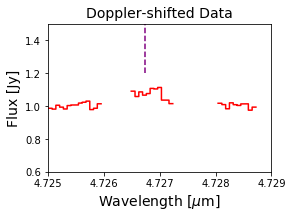

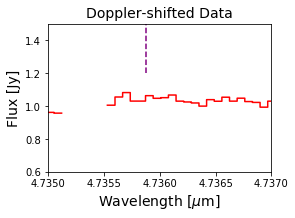

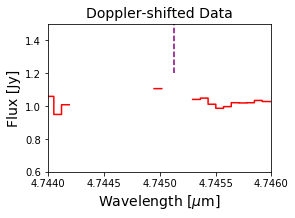

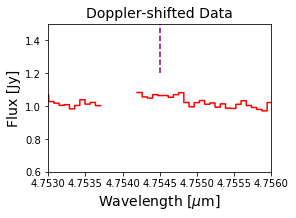

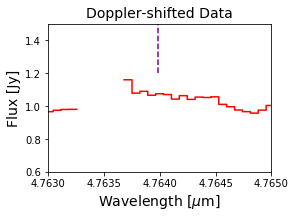

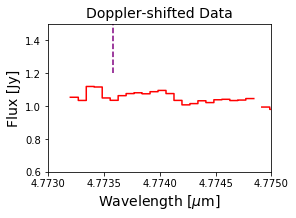

In [58]:
#Individual Line Profiles
fig =plt.figure(figsize(4,6))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(211)
ax3 = fig.add_subplot(211)
ax4 = fig.add_subplot(211)

left = 4.655
right = 4.658

plt.xlim([left,right])
plt.ylim([0.6,1.5])

plt.plot()
#ax1.plot(df1012['wave'],df1012['div'],linestyle='steps-mid', color = 'blue')
ax2.plot(df1212['wave'],df1212['div'],linestyle='steps-mid', color = 'red')
ax3.plot(df1013['wave'],df1013['div'],linestyle='steps-mid', color = 'green')
ax4.plot(df1213['wave'],df1213['div']-0.04,linestyle='steps-mid', color = 'orange')
ax4.vlines(4.657486, ymin=ymin, ymax=ymax, color='purple', linestyle='--')

ax1.set_title('Doppler-shifted Data', fontsize=14)
ax1.set_xlabel('Wavelength [$\mu$m]', fontsize=14)
ax1.set_ylabel('Flux [Jy]', fontsize=14)

#Emission Line 2
fig =plt.figure(figsize(4,6))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(211)
ax3 = fig.add_subplot(211)
ax4 = fig.add_subplot(211)

left = 4.681
right = 4.683

plt.xlim([left,right])
plt.ylim([0.6,1.5])

plt.plot()
#ax1.plot(df1012['wave'],df1012['div'],linestyle='steps-mid', color = 'blue')
ax2.plot(df1212['wave'],df1212['div'],linestyle='steps-mid', color = 'red')
ax3.plot(df1013['wave'],df1013['div'],linestyle='steps-mid', color = 'green')
ax4.plot(df1213['wave'],df1213['div'],linestyle='steps-mid', color = 'orange')
ax4.vlines(4.682643, ymin=ymin, ymax=ymax, color='purple', linestyle='--')

ax1.set_title('Doppler-shifted Data', fontsize=14)
ax1.set_xlabel('Wavelength [$\mu$m]', fontsize=14)
ax1.set_ylabel('Flux [Jy]', fontsize=14)

#Emission Line 3
fig =plt.figure(figsize(4,6))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(211)
ax3 = fig.add_subplot(211)
ax4 = fig.add_subplot(211)

left = 4.689
right = 4.692

plt.xlim([left,right])
plt.ylim([0.6,1.5])

plt.plot()
#ax1.plot(df1012['wave'],df1012['div'],linestyle='steps-mid', color = 'blue')
ax2.plot(df1212['wave'],df1212['div'],linestyle='steps-mid', color = 'red')
ax3.plot(df1013['wave'],df1013['div'],linestyle='steps-mid', color = 'green')
ax4.plot(df1213['wave'],df1213['div'],linestyle='steps-mid', color = 'orange')
ax4.vlines(4.691242, ymin=ymin, ymax=ymax, color='purple', linestyle='--')

ax1.set_title('Doppler-shifted Data', fontsize=14)
ax1.set_xlabel('Wavelength [$\mu$m]', fontsize=14)
ax1.set_ylabel('Flux [Jy]', fontsize=14)

#Emission Line 4
fig =plt.figure(figsize(4,6))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(211)
ax3 = fig.add_subplot(211)
ax4 = fig.add_subplot(211)

left = 4.706
right = 4.710

plt.xlim([left,right])
plt.ylim([0.6,1.5])

#ax1.plot(df1012['wave'],df1012['div'],linestyle='steps-mid', color = 'blue')
ax2.plot(df1212['wave'],df1212['div'],linestyle='steps-mid', color = 'red')
ax3.plot(df1013['wave'],df1013['div'],linestyle='steps-mid', color = 'green')
ax4.plot(df1213['wave'],df1213['div'],linestyle='steps-mid', color = 'orange')
ax4.vlines(4.708766, ymin=ymin, ymax=ymax, color='purple', linestyle='--')

ax1.set_title('Doppler-shifted Data', fontsize=14)
ax1.set_xlabel('Wavelength [$\mu$m]', fontsize=14)
ax1.set_ylabel('Flux [Jy]', fontsize=14)

#Emission Line 5
fig =plt.figure(figsize(4,6))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(211)
ax3 = fig.add_subplot(211)
ax4 = fig.add_subplot(211)

left = 4.716
right = 4.719

plt.xlim([left,right])
plt.ylim([0.6,1.5])

plt.plot()
#ax1.plot(df1012['wave'],df1012['div'],linestyle='steps-mid', color = 'blue')
ax2.plot(df1212['wave'],df1212['div'],linestyle='steps-mid', color = 'red')
ax3.plot(df1013['wave'],df1013['div'],linestyle='steps-mid', color = 'green')
ax4.plot(df1213['wave'],df1213['div'],linestyle='steps-mid', color = 'orange')
ax4.vlines(4.7176914, ymin=ymin, ymax=ymax, color='purple', linestyle='--')

ax1.set_title('Doppler-shifted Data', fontsize=14)
ax1.set_xlabel('Wavelength [$\mu$m]', fontsize=14)
ax1.set_ylabel('Flux [Jy]', fontsize=14)

#Emission Line 6
fig =plt.figure(figsize(4,6))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(211)
ax3 = fig.add_subplot(211)
ax4 = fig.add_subplot(211)

left = 4.725
right = 4.729

plt.xlim([left,right])
plt.ylim([0.6,1.5])

plt.plot()
#ax1.plot(df1012['wave'],df1012['div'],linestyle='steps-mid', color = 'blue')
ax2.plot(df1212['wave'],df1212['div'],linestyle='steps-mid', color = 'red')
ax3.plot(df1013['wave'],df1013['div'],linestyle='steps-mid', color = 'green')
ax4.plot(df1213['wave'],df1213['div'],linestyle='steps-mid', color = 'orange')
ax4.vlines(4.726727, ymin=ymin, ymax=ymax, color='purple', linestyle='--')

ax1.set_title('Doppler-shifted Data', fontsize=14)
ax1.set_xlabel('Wavelength [$\mu$m]', fontsize=14)
ax1.set_ylabel('Flux [Jy]', fontsize=14)

#Emission Line 7
fig =plt.figure(figsize(4,6))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(211)
ax3 = fig.add_subplot(211)
ax4 = fig.add_subplot(211)

left = 4.735
right = 4.737

plt.xlim([left,right])
plt.ylim([0.6,1.5])

plt.plot()
#ax1.plot(df1012['wave'],df1012['div'],linestyle='steps-mid', color = 'blue')
ax2.plot(df1212['wave'],df1212['div'],linestyle='steps-mid', color = 'red')
ax3.plot(df1013['wave'],df1013['div'],linestyle='steps-mid', color = 'green')
ax4.plot(df1213['wave'],df1213['div'],linestyle='steps-mid', color = 'orange')
ax4.vlines(4.735873, ymin=ymin, ymax=ymax, color='purple', linestyle='--')

ax1.set_title('Doppler-shifted Data', fontsize=14)
ax1.set_xlabel('Wavelength [$\mu$m]', fontsize=14)
ax1.set_ylabel('Flux [Jy]', fontsize=14)

#Emission Line 8
fig =plt.figure(figsize(4,6))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(211)
ax3 = fig.add_subplot(211)
ax4 = fig.add_subplot(211)

left = 4.744
right = 4.746

plt.xlim([left,right])
plt.ylim([0.6,1.5])

plt.plot()
#ax1.plot(df1012['wave'],df1012['div'],linestyle='steps-mid', color = 'blue')
ax2.plot(df1212['wave'],df1212['div'],linestyle='steps-mid', color = 'red')
ax3.plot(df1013['wave'],df1013['div'],linestyle='steps-mid', color = 'green')
ax4.plot(df1213['wave'],df1213['div'],linestyle='steps-mid', color = 'orange')
ax4.vlines(4.745131, ymin=ymin, ymax=ymax, color='purple', linestyle='--')

ax1.set_title('Doppler-shifted Data', fontsize=14)
ax1.set_xlabel('Wavelength [$\mu$m]', fontsize=14)
ax1.set_ylabel('Flux [Jy]', fontsize=14)

#Emission Line 9
fig =plt.figure(figsize(4,6))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(211)
ax3 = fig.add_subplot(211)
ax4 = fig.add_subplot(211)

left = 4.753
right = 4.756

plt.xlim([left,right])
plt.ylim([0.6,1.5])

plt.plot()
#ax1.plot(df1012['wave'],df1012['div'],linestyle='steps-mid', color = 'blue')
ax2.plot(df1212['wave'],df1212['div'],linestyle='steps-mid', color = 'red')
ax3.plot(df1013['wave'],df1013['div'],linestyle='steps-mid', color = 'green')
ax4.plot(df1213['wave'],df1213['div'],linestyle='steps-mid', color = 'orange')
ax4.vlines(4.754502, ymin=ymin, ymax=ymax, color='purple', linestyle='--')

ax1.set_title('Doppler-shifted Data', fontsize=14)
ax1.set_xlabel('Wavelength [$\mu$m]', fontsize=14)
ax1.set_ylabel('Flux [Jy]', fontsize=14)

#Emission Line 10 (0)
fig =plt.figure(figsize(4,6))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(211)
ax3 = fig.add_subplot(211)
ax4 = fig.add_subplot(211)

left = 4.763
right = 4.765

plt.xlim([left,right])
plt.ylim([0.6,1.5])

plt.plot()
#ax1.plot(df1012['wave'],df1012['div'],linestyle='steps-mid', color = 'blue')
ax2.plot(df1212['wave'],df1212['div'],linestyle='steps-mid', color = 'red')
ax3.plot(df1013['wave'],df1013['div'],linestyle='steps-mid', color = 'green')
ax4.plot(df1213['wave'],df1213['div'],linestyle='steps-mid', color = 'orange')
ax4.vlines(4.7639856, ymin=ymin, ymax=ymax, color='purple', linestyle='--')

ax1.set_title('Doppler-shifted Data', fontsize=14)
ax1.set_xlabel('Wavelength [$\mu$m]', fontsize=14)
ax1.set_ylabel('Flux [Jy]', fontsize=14)

#Emission Line 11
fig =plt.figure(figsize(4,6))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(211)
ax3 = fig.add_subplot(211)
ax4 = fig.add_subplot(211)

left = 4.773
right = 4.775

plt.xlim([left,right])
plt.ylim([0.6,1.5])

plt.plot()
#ax1.plot(df1012['wave'],df1012['div'],linestyle='steps-mid', color = 'blue')
ax2.plot(df1212['wave'],df1212['div'],linestyle='steps-mid', color = 'red')
ax3.plot(df1013['wave'],df1013['div'],linestyle='steps-mid', color = 'green')
ax4.plot(df1213['wave'],df1213['div'],linestyle='steps-mid', color = 'orange')
ax2.vlines(4.7735834, ymin=ymin, ymax=ymax, color='purple', linestyle='--')

ax1.set_title('Doppler-shifted Data', fontsize=14)
ax1.set_xlabel('Wavelength [$\mu$m]', fontsize=14)
ax1.set_ylabel('Flux [Jy]', fontsize=14)

Text(0, 0.5, 'Flux [Jy]')

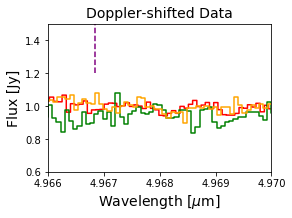

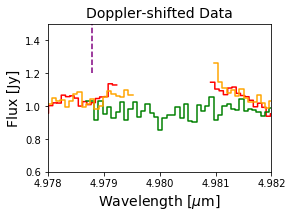

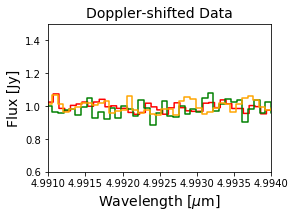

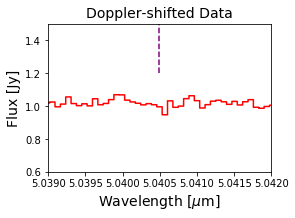

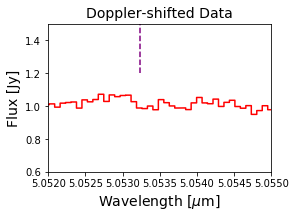

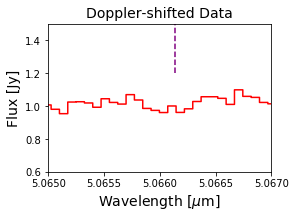

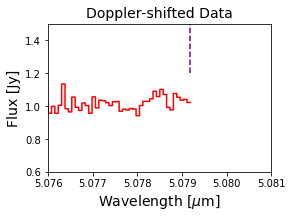

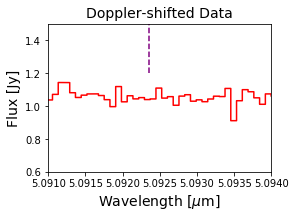

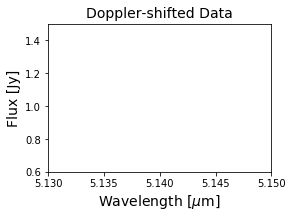

In [64]:
#Emission Line 12
fig =plt.figure(figsize(4,6))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(211)
ax3 = fig.add_subplot(211)
ax4 = fig.add_subplot(211)

left = 4.966
right = 4.970

plt.xlim([left,right])
plt.ylim([0.6,1.5])

plt.plot()
#ax1.plot(df1012['wave'],df1012['div'],linestyle='steps-mid', color = 'blue')
ax2.plot(df1212['wave'],df1212['div'],linestyle='steps-mid', color = 'red')
ax3.plot(df1013['wave'],df1013['div'],linestyle='steps-mid', color = 'green')
ax4.plot(df1213['wave'],df1213['div'],linestyle='steps-mid', color = 'orange')
ax3.vlines(4.9668403, ymin=ymin, ymax=ymax, color='purple', linestyle='--')

ax1.set_title('Doppler-shifted Data', fontsize=14)
ax1.set_xlabel('Wavelength [$\mu$m]', fontsize=14)
ax1.set_ylabel('Flux [Jy]', fontsize=14)

#Emission Line 13
fig =plt.figure(figsize(4,6))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(211)
ax3 = fig.add_subplot(211)
ax4 = fig.add_subplot(211)

left = 4.978
right = 4.982

plt.xlim([left,right])
plt.ylim([0.6,1.5])

plt.plot()
#ax1.plot(df1012['wave'],df1012['div'],linestyle='steps-mid', color = 'blue')
ax2.plot(df1212['wave'],df1212['div'],linestyle='steps-mid', color = 'red')
ax3.plot(df1013['wave'],df1013['div'],linestyle='steps-mid', color = 'green')
ax4.plot(df1213['wave'],df1213['div'],linestyle='steps-mid', color = 'orange')
ax3.vlines(4.978777, ymin=ymin, ymax=ymax, color='purple', linestyle='--')

ax1.set_title('Doppler-shifted Data', fontsize=14)
ax1.set_xlabel('Wavelength [$\mu$m]', fontsize=14)
ax1.set_ylabel('Flux [Jy]', fontsize=14)

#Emission Line 14
fig =plt.figure(figsize(4,6))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(211)
ax3 = fig.add_subplot(211)
ax4 = fig.add_subplot(211)

left = 4.991
right = 4.994

plt.xlim([left,right])
plt.ylim([0.6,1.5])

plt.plot()
#ax1.plot(df1012['wave'],df1012['div'],linestyle='steps-mid', color = 'blue')
ax2.plot(df1212['wave'],df1212['div'],linestyle='steps-mid', color = 'red')
ax3.plot(df1013['wave'],df1013['div'],linestyle='steps-mid', color = 'green')
ax4.plot(df1213['wave'],df1213['div'],linestyle='steps-mid', color = 'orange')
ax3.vlines(4.9908466, ymin=ymin, ymax=ymax, color='purple', linestyle='--')

ax1.set_title('Doppler-shifted Data', fontsize=14)
ax1.set_xlabel('Wavelength [$\mu$m]', fontsize=14)
ax1.set_ylabel('Flux [Jy]', fontsize=14)

#Emission Line 15
fig =plt.figure(figsize(4,6))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(211)
ax3 = fig.add_subplot(211)
ax4 = fig.add_subplot(211)

left = 5.039
right = 5.042

plt.xlim([left,right])
plt.ylim([0.6,1.5])

plt.plot()
#ax1.plot(df1012['wave'],df1012['div'],linestyle='steps-mid', color = 'blue')
ax2.plot(df1212['wave'],df1212['div'],linestyle='steps-mid', color = 'red')
ax3.plot(df1013['wave'],df1013['div'],linestyle='steps-mid', color = 'green')
ax4.plot(df1213['wave'],df1213['div'],linestyle='steps-mid', color = 'orange')
ax3.vlines(5.0404844, ymin=ymin, ymax=ymax, color='purple', linestyle='--')

ax1.set_title('Doppler-shifted Data', fontsize=14)
ax1.set_xlabel('Wavelength [$\mu$m]', fontsize=14)
ax1.set_ylabel('Flux [Jy]', fontsize=14)

#Emission Line 16
fig =plt.figure(figsize(4,6))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(211)
ax3 = fig.add_subplot(211)
ax4 = fig.add_subplot(211)

left = 5.052
right = 5.055

plt.xlim([left,right])
plt.ylim([0.6,1.5])

plt.plot()
#ax1.plot(df1012['wave'],df1012['div'],linestyle='steps-mid', color = 'blue')
ax2.plot(df1212['wave'],df1212['div'],linestyle='steps-mid', color = 'red')
ax3.plot(df1013['wave'],df1013['div'],linestyle='steps-mid', color = 'green')
ax4.plot(df1213['wave'],df1213['div'],linestyle='steps-mid', color = 'orange')
ax3.vlines(5.0532393, ymin=ymin, ymax=ymax, color='purple', linestyle='--')

ax1.set_title('Doppler-shifted Data', fontsize=14)
ax1.set_xlabel('Wavelength [$\mu$m]', fontsize=14)
ax1.set_ylabel('Flux [Jy]', fontsize=14)

#Emission Line 17
fig =plt.figure(figsize(4,6))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(211)
ax3 = fig.add_subplot(211)
ax4 = fig.add_subplot(211)

left = 5.065
right = 5.067

plt.xlim([left,right])
plt.ylim([0.6,1.5])

plt.plot()
#ax1.plot(df1012['wave'],df1012['div'],linestyle='steps-mid', color = 'blue')
ax2.plot(df1212['wave'],df1212['div'],linestyle='steps-mid', color = 'red')
ax3.plot(df1013['wave'],df1013['div'],linestyle='steps-mid', color = 'green')
ax4.plot(df1213['wave'],df1213['div'],linestyle='steps-mid', color = 'orange')
ax3.vlines(5.0661345, ymin=ymin, ymax=ymax, color='purple', linestyle='--')

ax1.set_title('Doppler-shifted Data', fontsize=14)
ax1.set_xlabel('Wavelength [$\mu$m]', fontsize=14)
ax1.set_ylabel('Flux [Jy]', fontsize=14)

#Emission Line 18
fig =plt.figure(figsize(4,6))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(211)
ax3 = fig.add_subplot(211)
ax4 = fig.add_subplot(211)

left = 5.076
right = 5.081

plt.xlim([left,right])
plt.ylim([0.6,1.5])

plt.plot()
#ax1.plot(df1012['wave'],df1012['div'],linestyle='steps-mid', color = 'blue')
ax2.plot(df1212['wave'],df1212['div'],linestyle='steps-mid', color = 'red')
ax3.plot(df1013['wave'],df1013['div'],linestyle='steps-mid', color = 'green')
ax4.plot(df1213['wave'],df1213['div'],linestyle='steps-mid', color = 'orange')
ax3.vlines(5.079172, ymin=ymin, ymax=ymax, color='purple', linestyle='--')

ax1.set_title('Doppler-shifted Data', fontsize=14)
ax1.set_xlabel('Wavelength [$\mu$m]', fontsize=14)
ax1.set_ylabel('Flux [Jy]', fontsize=14)

#Emission Line 19
fig =plt.figure(figsize(4,6))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(211)
ax3 = fig.add_subplot(211)
ax4 = fig.add_subplot(211)

left = 5.091
right = 5.094

plt.xlim([left,right])
plt.ylim([0.6,1.5])

plt.plot()
#ax1.plot(df1012['wave'],df1012['div'],linestyle='steps-mid', color = 'blue')
ax2.plot(df1212['wave'],df1212['div'],linestyle='steps-mid', color = 'red')
ax3.plot(df1013['wave'],df1013['div'],linestyle='steps-mid', color = 'green')
ax4.plot(df1213['wave'],df1213['div'],linestyle='steps-mid', color = 'orange')
ax3.vlines(5.092353, ymin=ymin, ymax=ymax, color='purple', linestyle='--')

ax1.set_title('Doppler-shifted Data', fontsize=14)
ax1.set_xlabel('Wavelength [$\mu$m]', fontsize=14)
ax1.set_ylabel('Flux [Jy]', fontsize=14)

#Emission Line 20
fig =plt.figure(figsize(4,6))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(211)
ax3 = fig.add_subplot(211)
ax4 = fig.add_subplot(211)

left = 5.13
right = 5.15

plt.xlim([left,right])
plt.ylim([0.6,1.5])

plt.plot()
#ax1.plot(df1012['wave'],df1012['div'],linestyle='steps-mid', color = 'blue')
ax2.plot(df1212['wave'],df1212['div'],linestyle='steps-mid', color = 'red')
ax3.plot(df1013['wave'],df1013['div'],linestyle='steps-mid', color = 'green')
ax4.plot(df1213['wave'],df1213['div'],linestyle='steps-mid', color = 'orange')
ax3.vlines(5.092353, ymin=ymin, ymax=ymax, color='purple', linestyle='--')

ax1.set_title('Doppler-shifted Data', fontsize=14)
ax1.set_xlabel('Wavelength [$\mu$m]', fontsize=14)
ax1.set_ylabel('Flux [Jy]', fontsize=14)

Not enough data near  5.18900606925888  microns. Skipping.
Not enough data near  5.174782735717755  microns. Skipping.
Not enough data near  5.160712474562946  microns. Skipping.
Not enough data near  5.146793855211405  microns. Skipping.
Not enough data near  5.133025447080083  microns. Skipping.
Not enough data near  5.11940581958593  microns. Skipping.
Not enough data near  5.105934019006913  microns. Skipping.
Not enough data near  5.092607661037948  microns. Skipping.
Not enough data near  5.079426268818019  microns. Skipping.
Not enough data near  5.0663879349030605  microns. Skipping.
Not enough data near  5.053492182432055  microns. Skipping.
Not enough data near  5.04073662709992  microns. Skipping.


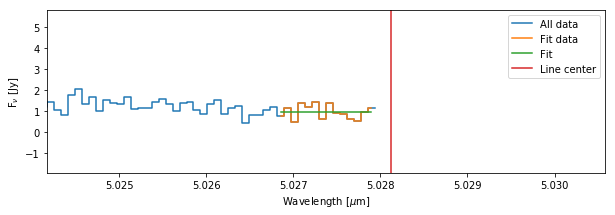

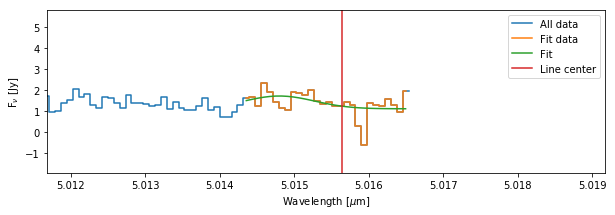

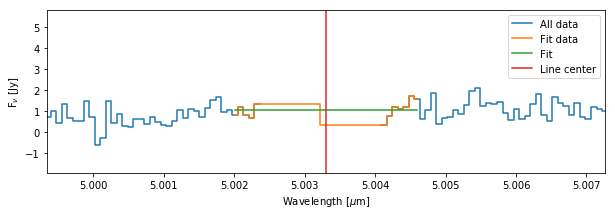

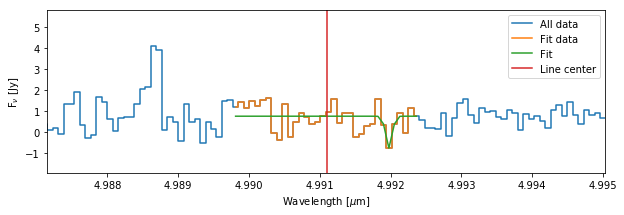

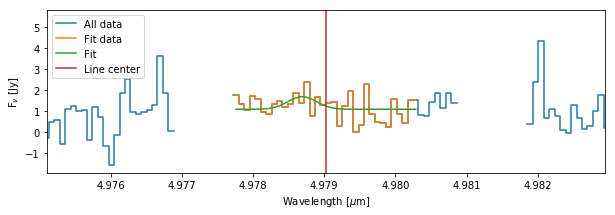

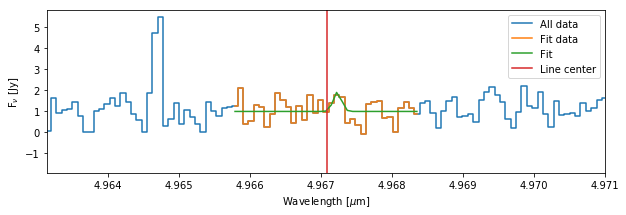

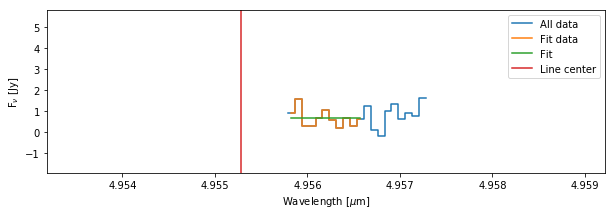

Not enough data near  4.94361005210669  microns. Skipping.
Not enough data near  4.93206620061765  microns. Skipping.
Not enough data near  4.9206515784641  microns. Skipping.
Not enough data near  4.90936475506299  microns. Skipping.
Not enough data near  4.898204776692286  microns. Skipping.
Not enough data near  4.887170689629956  microns. Skipping.
Not enough data near  4.87626106329295  microns. Skipping.
Not enough data near  4.865475420820251  microns. Skipping.
Not enough data near  4.854812808489826  microns. Skipping.
Not enough data near  4.844271795718625  microns. Skipping.
Not enough data near  4.833852382506649  microns. Skipping.
Not enough data near  4.823552184548815  microns. Skipping.
Not enough data near  4.8133716787061385  microns. Skipping.
Not enough data near  4.803309434395571  microns. Skipping.
Not enough data near  4.793363544173045  microns. Skipping.
Not enough data near  4.783535438621612  microns. Skipping.
Not enough data near  4.77382225657517  micro

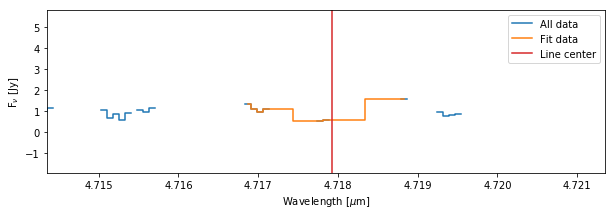

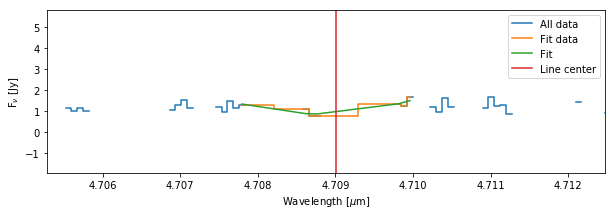

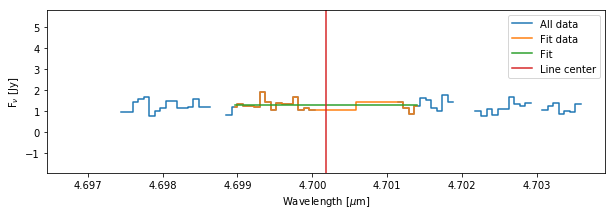

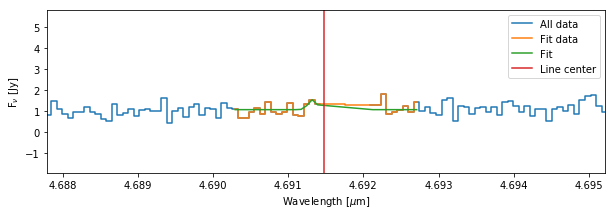

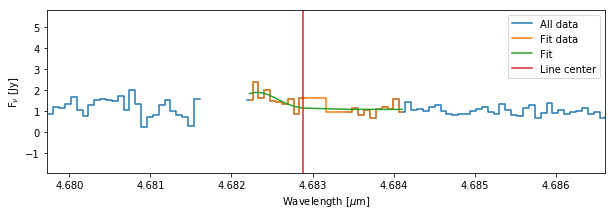

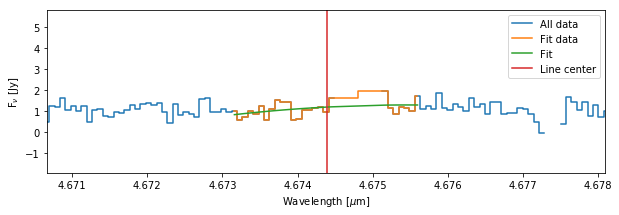

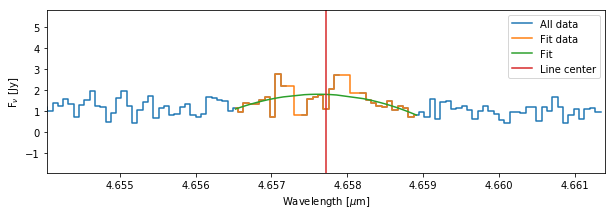

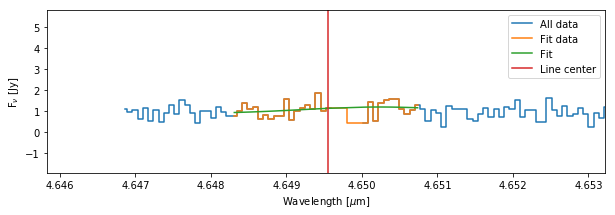

Not enough data near  4.641474250037329  microns. Skipping.
Not enough data near  4.633508286755587  microns. Skipping.
Not enough data near  4.625646279175457  microns. Skipping.
Not enough data near  4.617886796713888  microns. Skipping.
Not enough data near  4.610229362509864  microns. Skipping.
Not enough data near  4.602673976563386  microns. Skipping.
      linewidth      
        km / s       
---------------------
   13032.014721841555
    66.34110147037306
5.113204962271814e-05
   6.5101346535259035
    28.33174966687301
    8.255481294556812
   111526.74549685756
    4960.894023275729
   388.12793562126984
    8.604659340326126
    37.08850783906566
    5819.615274795112
   6295.6731771753575
     154.830169947011


"\n\n\nfwhm1012 = out['linewidth']\nerr1012 = [3.577082224511988,2.585988156854974,2.569180783346104,1.2442423017368787,1.35222308632202,136336.21213651364,0.950034368741535,6.600660724548445,3.52050474663863]\nlineflux_data = lineflux_data['wave']\na = np.array([])\nfor n in range(len(fwhm1213)):\n    if (fwhm1213[n] > 0):\n        wave_val = lineflux_data[n]\n        a = np.append(a, wave_val)\nprint(a)\nprint(out['linewidth']) #2\nprint(err1213)\nfwhm1213 = [37.243837378591124,38.34804717267784,32.0877941225196,30.817197422622204,38.94822457157716,8.84125562708433,32.87815292373069,32.25918029454974,28.268205867589487]\nplt.plot(fwhm1213, 'ro')\n"

In [79]:
#Read in HITRAN data
out_all=extract_hitran_data('CO',4.6,5.2)  #astropy table
lineflux_data=extract_vup(out_all,1)

#For Data2010121314
wave=df1012['wave']
flux=df1012['div']
out=calc_fluxes(wave,flux,lineflux_data,fwhm_v=17., sep_v=80., cont=1.12,vet_fits=False, plot=True, v_dop=15.)
rot1012=make_rotation_diagram(out)

'''


fwhm1012 = out['linewidth']
err1012 = [3.577082224511988,2.585988156854974,2.569180783346104,1.2442423017368787,1.35222308632202,136336.21213651364,0.950034368741535,6.600660724548445,3.52050474663863]
lineflux_data = lineflux_data['wave']
a = np.array([])
for n in range(len(fwhm1213)):
    if (fwhm1213[n] > 0):
        wave_val = lineflux_data[n]
        a = np.append(a, wave_val)
print(a)
print(out['linewidth']) #2
print(err1213)
fwhm1213 = [37.243837378591124,38.34804717267784,32.0877941225196,30.817197422622204,38.94822457157716,8.84125562708433,32.87815292373069,32.25918029454974,28.268205867589487]
plt.plot(fwhm1213, 'ro')
'''
#for xc in a:
    #plt.vlines(x=xc, ymin=0, ymax=40, color='purple', linestyle='--')

Not enough data near  5.18900606925888  microns. Skipping.
Not enough data near  5.174782735717755  microns. Skipping.
Not enough data near  5.160712474562946  microns. Skipping.
Not enough data near  5.146793855211405  microns. Skipping.
Not enough data near  5.133025447080083  microns. Skipping.
Not enough data near  5.11940581958593  microns. Skipping.
Not enough data near  5.105934019006913  microns. Skipping.


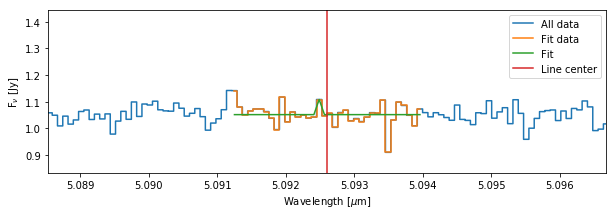

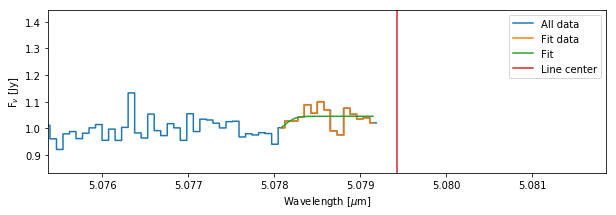

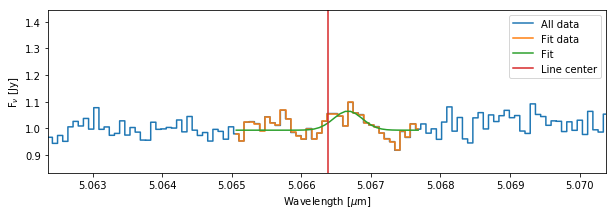

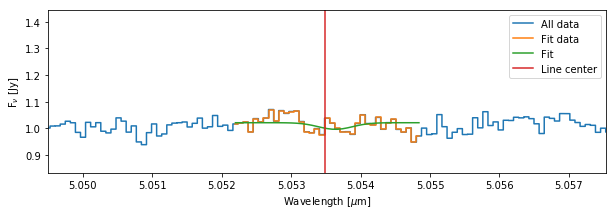

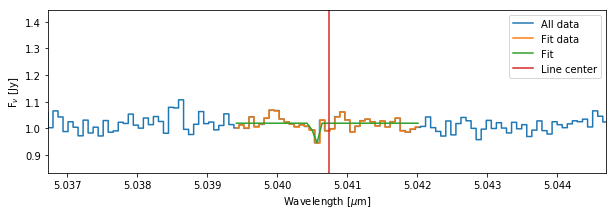

Not enough data near  5.028120792045639  microns. Skipping.
Not enough data near  5.015642769825146  microns. Skipping.


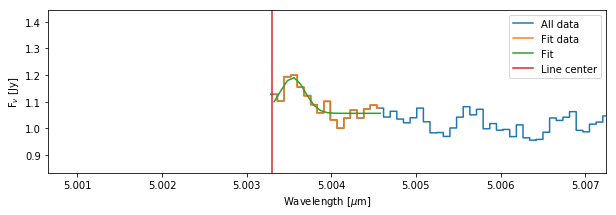

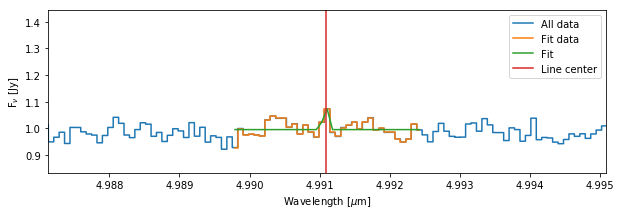

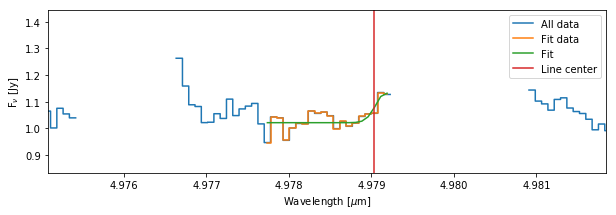

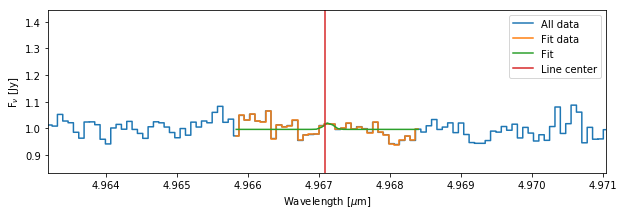

Not enough data near  4.955284086653252  microns. Skipping.
Not enough data near  4.94361005210669  microns. Skipping.
Not enough data near  4.93206620061765  microns. Skipping.
Not enough data near  4.9206515784641  microns. Skipping.
Not enough data near  4.90936475506299  microns. Skipping.
Not enough data near  4.898204776692286  microns. Skipping.
Not enough data near  4.887170689629956  microns. Skipping.
Not enough data near  4.87626106329295  microns. Skipping.
Not enough data near  4.865475420820251  microns. Skipping.
Not enough data near  4.854812808489826  microns. Skipping.
Not enough data near  4.844271795718625  microns. Skipping.
Not enough data near  4.833852382506649  microns. Skipping.
Not enough data near  4.823552184548815  microns. Skipping.
Not enough data near  4.8133716787061385  microns. Skipping.
Not enough data near  4.803309434395571  microns. Skipping.
Not enough data near  4.793363544173045  microns. Skipping.
Not enough data near  4.783535438621612  micr

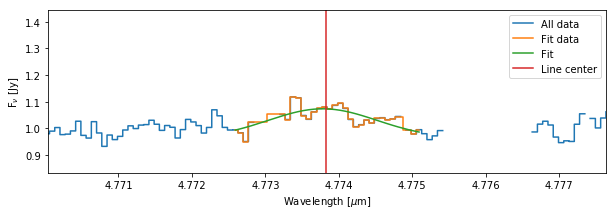

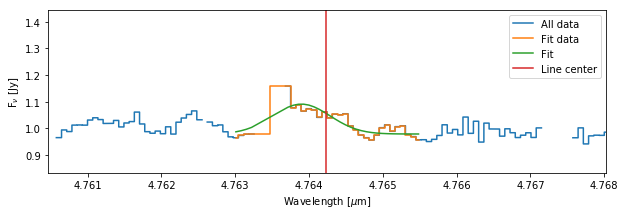

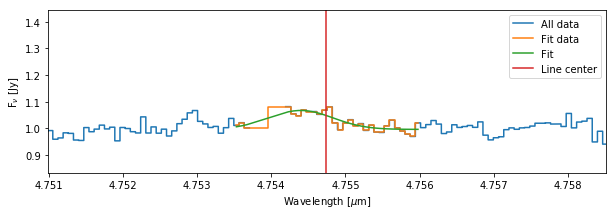

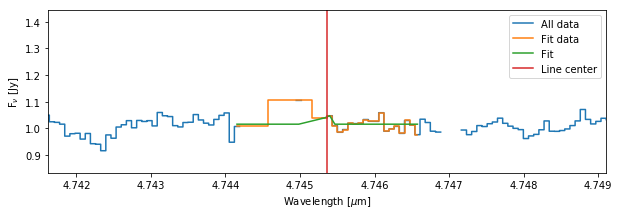

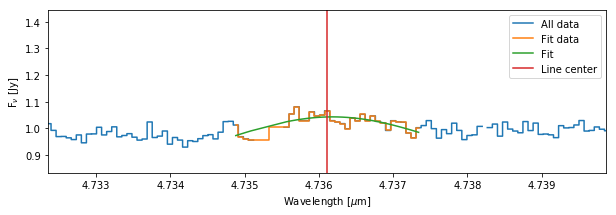

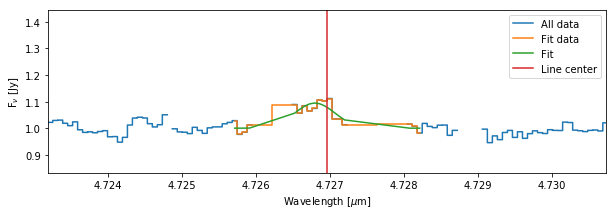

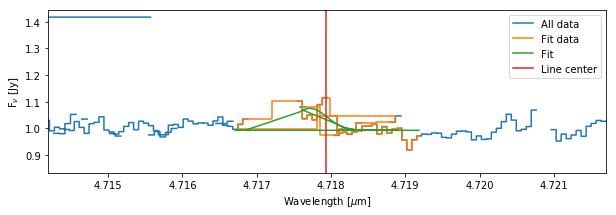

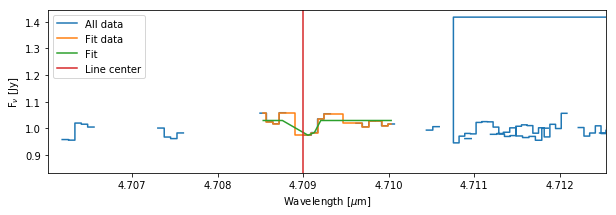

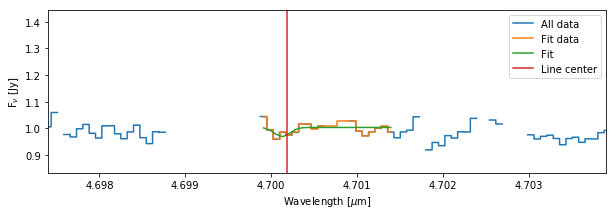

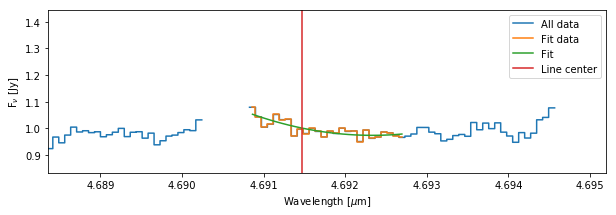

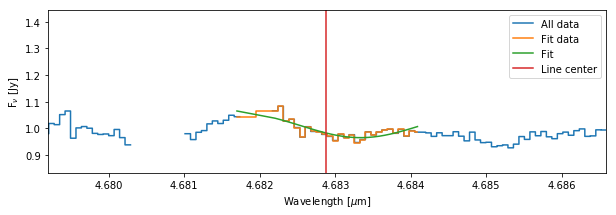

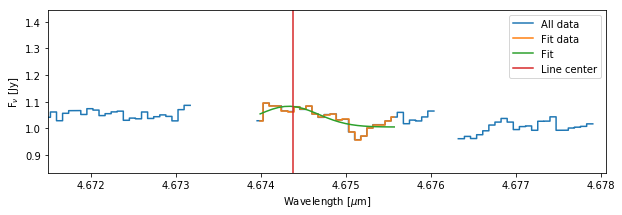

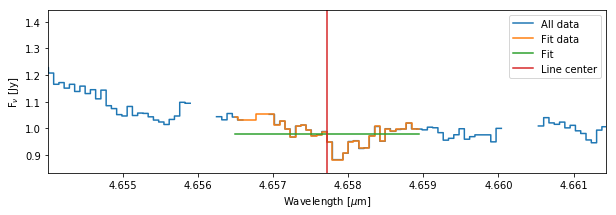

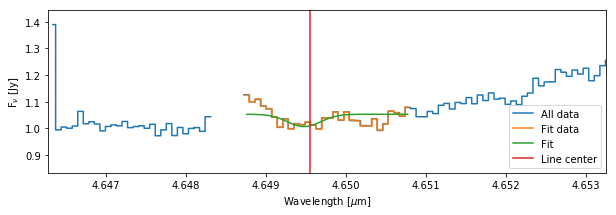

Not enough data near  4.641474250037329  microns. Skipping.
Not enough data near  4.633508286755587  microns. Skipping.
Not enough data near  4.625646279175457  microns. Skipping.
Not enough data near  4.617886796713888  microns. Skipping.
Not enough data near  4.610229362509864  microns. Skipping.
Not enough data near  4.602673976563386  microns. Skipping.
    linewidth     
      km / s      
------------------
0.7201513740268164
 16.60589072143972
 28.64453975302933
 34.38503422487067
 2.658448544907442
20.596870165079288
2.9164121904658313
16.749349119872925
 9.101929946045125
109.30995850988927
               ...
219.82611867112652
 40.22688930942595
33.831372412271904
2.9452947337325783
13.375786125468798
 8928.987231358244
118.53131127090606
   53.161790813824
0.7700788629731486
31.416523700613066
Length = 23 rows


"\nfwhm1012 = out['linewidth']\nerr1012 = [3.577082224511988,2.585988156854974,2.569180783346104,1.2442423017368787,1.35222308632202,136336.21213651364,0.950034368741535,6.600660724548445,3.52050474663863]\nlineflux_data = lineflux_data['wave']\na = np.array([])\nfor n in range(len(fwhm1213)):\n    if (fwhm1213[n] > 0):\n        wave_val = lineflux_data[n]\n        a = np.append(a, wave_val)\nprint(a)\nprint(out['linewidth']) #2\nprint(err1213)\nfwhm1213 = [37.243837378591124,38.34804717267784,32.0877941225196,30.817197422622204,38.94822457157716,8.84125562708433,32.87815292373069,32.25918029454974,28.268205867589487]\nplt.plot(fwhm1213, 'ro')\n"

In [80]:
#Read in HITRAN data
out_all=extract_hitran_data('CO',4.6,5.2)  #astropy table
lineflux_data=extract_vup(out_all,1)

#For Data2010121314
wave=df1212['wave']
flux=df1212['div']
out=calc_fluxes(wave,flux,lineflux_data,fwhm_v=17., sep_v=80., cont=1.12,vet_fits=False, plot=True, v_dop=15.)
rot1212=make_rotation_diagram(out)
print(out['linewidth'])
'''
fwhm1012 = out['linewidth']
err1012 = [3.577082224511988,2.585988156854974,2.569180783346104,1.2442423017368787,1.35222308632202,136336.21213651364,0.950034368741535,6.600660724548445,3.52050474663863]
lineflux_data = lineflux_data['wave']
a = np.array([])
for n in range(len(fwhm1213)):
    if (fwhm1213[n] > 0):
        wave_val = lineflux_data[n]
        a = np.append(a, wave_val)
print(a)
print(out['linewidth']) #2
print(err1213)
fwhm1213 = [37.243837378591124,38.34804717267784,32.0877941225196,30.817197422622204,38.94822457157716,8.84125562708433,32.87815292373069,32.25918029454974,28.268205867589487]
plt.plot(fwhm1213, 'ro')
'''
#for xc in a:
    #plt.vlines(x=xc, ymin=0, ymax=40, color='purple', linestyle='--')

Not enough data near  5.18900606925888  microns. Skipping.
Not enough data near  5.174782735717755  microns. Skipping.
Not enough data near  5.160712474562946  microns. Skipping.
Not enough data near  5.146793855211405  microns. Skipping.
Not enough data near  5.133025447080083  microns. Skipping.
Not enough data near  5.11940581958593  microns. Skipping.
Not enough data near  5.105934019006913  microns. Skipping.
Not enough data near  5.092607661037948  microns. Skipping.
Not enough data near  5.079426268818019  microns. Skipping.
Not enough data near  5.0663879349030605  microns. Skipping.
Not enough data near  5.053492182432055  microns. Skipping.
Not enough data near  5.04073662709992  microns. Skipping.
Not enough data near  5.028120792045639  microns. Skipping.
Not enough data near  5.015642769825146  microns. Skipping.


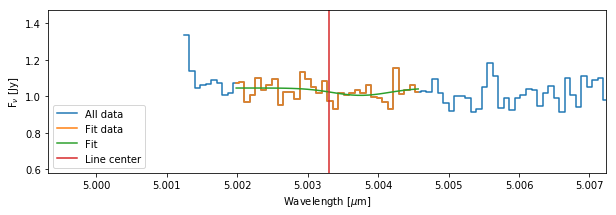

Error - curve_fit failed


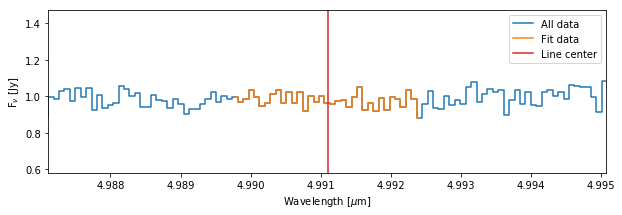

Error - curve_fit failed


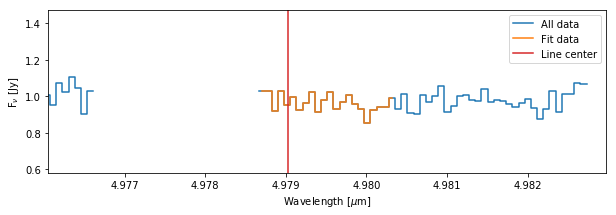

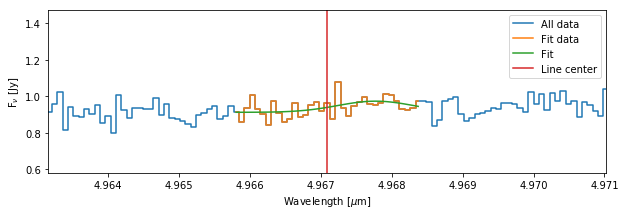

Not enough data near  4.955284086653252  microns. Skipping.
Not enough data near  4.94361005210669  microns. Skipping.
Not enough data near  4.93206620061765  microns. Skipping.
Not enough data near  4.9206515784641  microns. Skipping.
Not enough data near  4.90936475506299  microns. Skipping.
Not enough data near  4.898204776692286  microns. Skipping.
Not enough data near  4.887170689629956  microns. Skipping.
Not enough data near  4.87626106329295  microns. Skipping.
Not enough data near  4.865475420820251  microns. Skipping.
Not enough data near  4.854812808489826  microns. Skipping.
Not enough data near  4.844271795718625  microns. Skipping.
Not enough data near  4.833852382506649  microns. Skipping.
Not enough data near  4.823552184548815  microns. Skipping.
Not enough data near  4.8133716787061385  microns. Skipping.
Not enough data near  4.803309434395571  microns. Skipping.
Not enough data near  4.793363544173045  microns. Skipping.
Not enough data near  4.783535438621612  micr

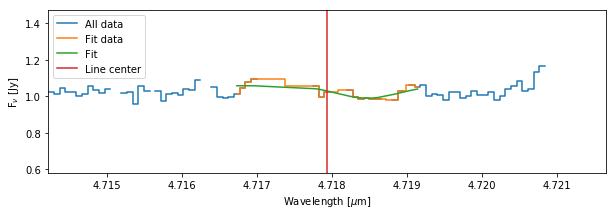

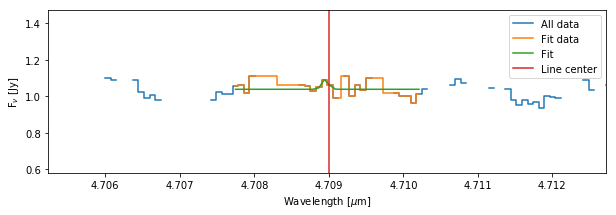

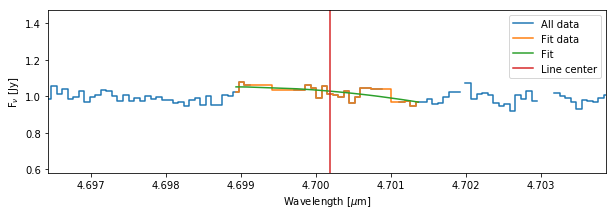

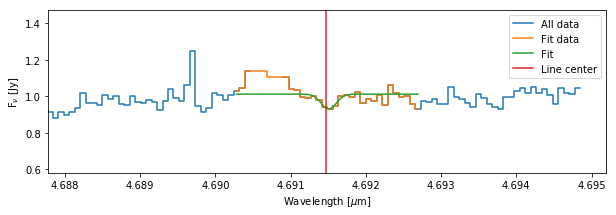

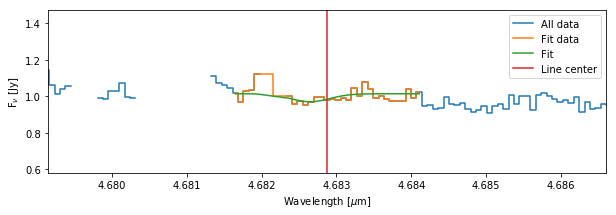

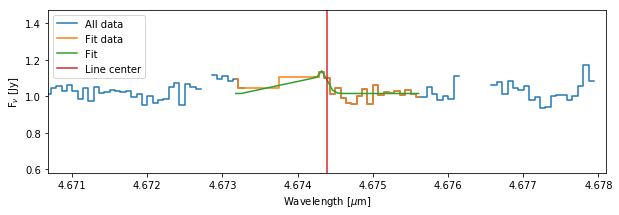

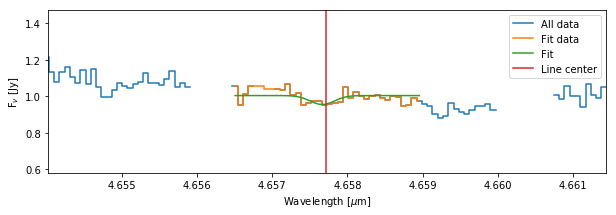

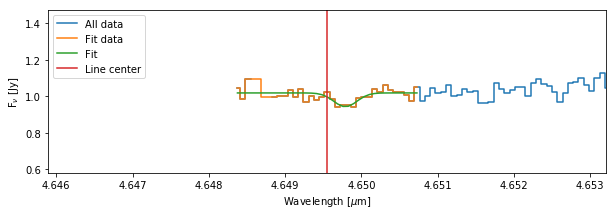

Not enough data near  4.641474250037329  microns. Skipping.
Not enough data near  4.633508286755587  microns. Skipping.
Not enough data near  4.625646279175457  microns. Skipping.
Not enough data near  4.617886796713888  microns. Skipping.
Not enough data near  4.610229362509864  microns. Skipping.
Not enough data near  4.602673976563386  microns. Skipping.


"\nprint(out['linewidth'])\n\nfwhm1012 = out['linewidth']\nerr1012 = [3.577082224511988,2.585988156854974,2.569180783346104,1.2442423017368787,1.35222308632202,136336.21213651364,0.950034368741535,6.600660724548445,3.52050474663863]\nlineflux_data = lineflux_data['wave']\na = np.array([])\nfor n in range(len(fwhm1213)):\n    if (fwhm1213[n] > 0):\n        wave_val = lineflux_data[n]\n        a = np.append(a, wave_val)\nprint(a)\nprint(out['linewidth']) #2\nprint(err1213)\nfwhm1213 = [37.243837378591124,38.34804717267784,32.0877941225196,30.817197422622204,38.94822457157716,8.84125562708433,32.87815292373069,32.25918029454974,28.268205867589487]\nplt.plot(fwhm1213, 'ro')\n"

In [72]:
#Read in HITRAN data
out_all=extract_hitran_data('CO',4.6,5.2)  #astropy table
lineflux_data=extract_vup(out_all,1)

#For Data2010121314
wave=df1013['wave']
flux=df1013['div']
out=calc_fluxes(wave,flux,lineflux_data,fwhm_v=17., sep_v=80., cont=1.12,vet_fits=False, plot=True, v_dop=15.)
rot1013=make_rotation_diagram(out)
'''
print(out['linewidth'])

fwhm1012 = out['linewidth']
err1012 = [3.577082224511988,2.585988156854974,2.569180783346104,1.2442423017368787,1.35222308632202,136336.21213651364,0.950034368741535,6.600660724548445,3.52050474663863]
lineflux_data = lineflux_data['wave']
a = np.array([])
for n in range(len(fwhm1213)):
    if (fwhm1213[n] > 0):
        wave_val = lineflux_data[n]
        a = np.append(a, wave_val)
print(a)
print(out['linewidth']) #2
print(err1213)
fwhm1213 = [37.243837378591124,38.34804717267784,32.0877941225196,30.817197422622204,38.94822457157716,8.84125562708433,32.87815292373069,32.25918029454974,28.268205867589487]
plt.plot(fwhm1213, 'ro')
'''
#for xc in a:
    #plt.vlines(x=xc, ymin=0, ymax=40, color='purple', linestyle='--')

Not enough data near  5.18900606925888  microns. Skipping.
Not enough data near  5.174782735717755  microns. Skipping.
Not enough data near  5.160712474562946  microns. Skipping.
Not enough data near  5.146793855211405  microns. Skipping.
Not enough data near  5.133025447080083  microns. Skipping.
Not enough data near  5.11940581958593  microns. Skipping.
Not enough data near  5.105934019006913  microns. Skipping.
Not enough data near  5.092607661037948  microns. Skipping.
Not enough data near  5.079426268818019  microns. Skipping.
Not enough data near  5.0663879349030605  microns. Skipping.
Not enough data near  5.053492182432055  microns. Skipping.
Not enough data near  5.04073662709992  microns. Skipping.
Not enough data near  5.028120792045639  microns. Skipping.
Not enough data near  5.015642769825146  microns. Skipping.


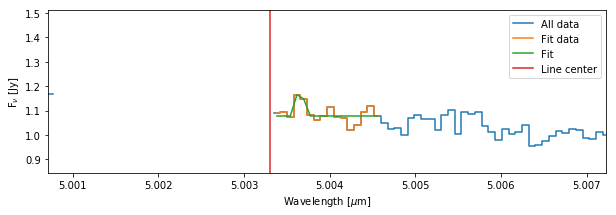

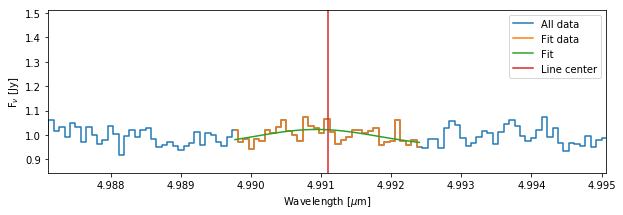

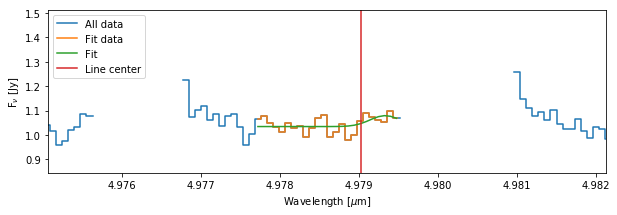

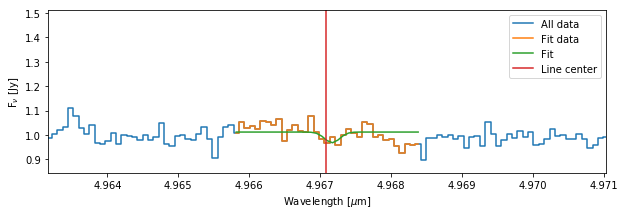

Not enough data near  4.955284086653252  microns. Skipping.
Not enough data near  4.94361005210669  microns. Skipping.
Not enough data near  4.93206620061765  microns. Skipping.
Not enough data near  4.9206515784641  microns. Skipping.
Not enough data near  4.90936475506299  microns. Skipping.
Not enough data near  4.898204776692286  microns. Skipping.
Not enough data near  4.887170689629956  microns. Skipping.
Not enough data near  4.87626106329295  microns. Skipping.
Not enough data near  4.865475420820251  microns. Skipping.
Not enough data near  4.854812808489826  microns. Skipping.
Not enough data near  4.844271795718625  microns. Skipping.
Not enough data near  4.833852382506649  microns. Skipping.
Not enough data near  4.823552184548815  microns. Skipping.
Not enough data near  4.8133716787061385  microns. Skipping.
Not enough data near  4.803309434395571  microns. Skipping.
Not enough data near  4.793363544173045  microns. Skipping.
Not enough data near  4.783535438621612  micr

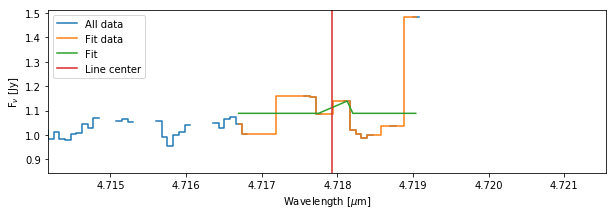

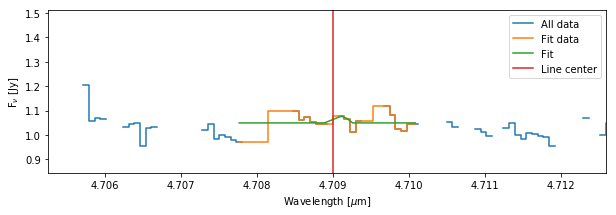

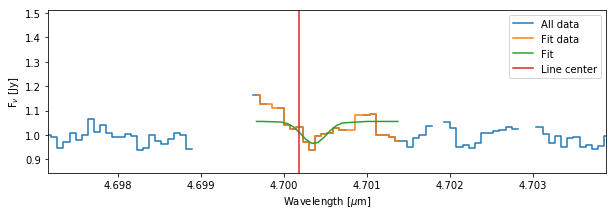

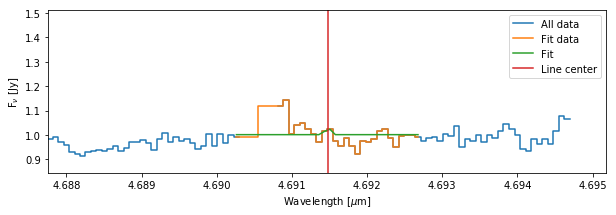

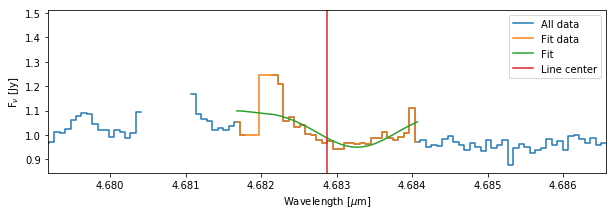

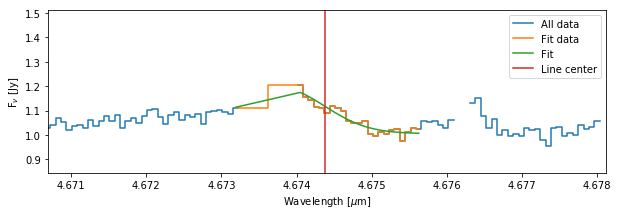

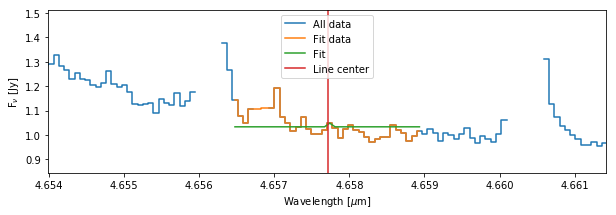

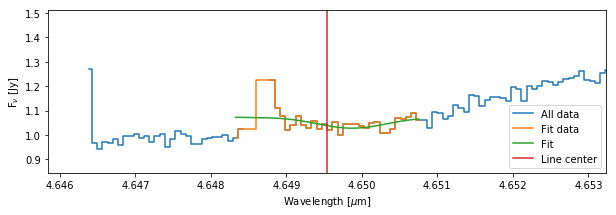

Not enough data near  4.641474250037329  microns. Skipping.
Not enough data near  4.633508286755587  microns. Skipping.
Not enough data near  4.625646279175457  microns. Skipping.
Not enough data near  4.617886796713888  microns. Skipping.
Not enough data near  4.610229362509864  microns. Skipping.
Not enough data near  4.602673976563386  microns. Skipping.


"\nprint(out['linewidth'])\n\nfwhm1012 = out['linewidth']\nerr1012 = [3.577082224511988,2.585988156854974,2.569180783346104,1.2442423017368787,1.35222308632202,136336.21213651364,0.950034368741535,6.600660724548445,3.52050474663863]\nlineflux_data = lineflux_data['wave']\na = np.array([])\nfor n in range(len(fwhm1213)):\n    if (fwhm1213[n] > 0):\n        wave_val = lineflux_data[n]\n        a = np.append(a, wave_val)\nprint(a)\nprint(out['linewidth']) #2\nprint(err1213)\nfwhm1213 = [37.243837378591124,38.34804717267784,32.0877941225196,30.817197422622204,38.94822457157716,8.84125562708433,32.87815292373069,32.25918029454974,28.268205867589487]\nplt.plot(fwhm1213, 'ro')\n"

In [73]:
#Read in HITRAN data
out_all=extract_hitran_data('CO',4.6,5.2)  #astropy table
lineflux_data=extract_vup(out_all,1)

#For Data2010121314
wave=df1213['wave']
flux=df1213['div']
out=calc_fluxes(wave,flux,lineflux_data,fwhm_v=17., sep_v=80., cont=1.12,vet_fits=False, plot=True, v_dop=15.)
rot1213=make_rotation_diagram(out)
'''
print(out['linewidth'])

fwhm1012 = out['linewidth']
err1012 = [3.577082224511988,2.585988156854974,2.569180783346104,1.2442423017368787,1.35222308632202,136336.21213651364,0.950034368741535,6.600660724548445,3.52050474663863]
lineflux_data = lineflux_data['wave']
a = np.array([])
for n in range(len(fwhm1213)):
    if (fwhm1213[n] > 0):
        wave_val = lineflux_data[n]
        a = np.append(a, wave_val)
print(a)
print(out['linewidth']) #2
print(err1213)
fwhm1213 = [37.243837378591124,38.34804717267784,32.0877941225196,30.817197422622204,38.94822457157716,8.84125562708433,32.87815292373069,32.25918029454974,28.268205867589487]
plt.plot(fwhm1213, 'ro')
'''
#for xc in a:
    #plt.vlines(x=xc, ymin=0, ymax=40, color='purple', linestyle='--')

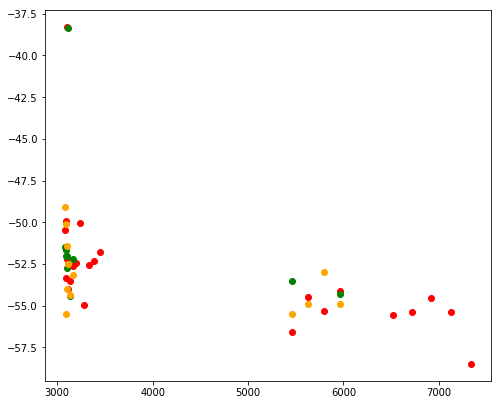

In [78]:
fig =plt.figure(figsize(8,15))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(211)
ax3 = fig.add_subplot(211)
ax4 = fig.add_subplot(211)


plt.plot()
#ax1.plot(rot1012['x'],rot1012['y'],'bo')
ax2.plot(rot1212['x'],rot1212['y'],'ro')
ax3.plot(rot1013['x'],rot1013['y'],'go')
ax3.plot(rot1213['x'],rot1213['y'],'o', color = 'orange')